# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

+ Интернет+безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
+ Выделенная линия технической поддержки (*TechSupport*);
+ Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
+ Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

+ `contract_new.csv` — информация о договоре;
+ `personal_new.csv` — персональные данные клиента;
+ `internet_new.csv` — информация об интернет+услугах;
+ `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка и ознакомление с данными

In [1]:
%%capture
!pip install phik

In [2]:
%%capture
!pip install ydata-profiling;

In [3]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

random_state = 150523

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Замечаем неподходящий `TotalCharges` тип данных и тут же его меняем.

In [7]:
contract.loc[contract['TotalCharges'] == ' ']
# пустые значения в типе object оказались пробелами, заполним их нулями

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [8]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)

In [9]:
# теперь изменим тип данных
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [10]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
# объединим 4 таблицы в одну
contract_personal = contract.merge(personal, on='customerID', how='left')
contract_personal_internet = contract_personal.merge(internet, on='customerID', how='left')
df = contract_personal_internet.merge(phone, on='customerID', how='left')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


**Выводы**

Предположительно, в таблице `internet` попросту отстувуют данные о пользователях, у которых не подключена услуга, при объединении таблиц закономерно образуются пропуски, которые мы заполним соотвествующим значением. 
В таблице `phone` затруднительно восстановить информацию о возможности подключения телефонного аппарата к нескольким линиям одновременно, поэтому предположим, что такая опция у пользователя отсутсвует.
Тут же приведем названия стоблцов к змеиному виду.

## Первичный анализ данных

In [18]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', ' ', col).lower().replace(' ', '_') for col in df.columns]
df.rename(columns={'customer_i_d': 'customer_id', 'streaming_t_v': 'streaming_tv'}, inplace=True)
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [20]:
corr_df = df.drop(['customer_id'], axis=1)
interval_cols = ['monthly_charges', 'total_charges', 'senior_citizen']
corr_report = corr_df.phik_matrix(interval_cols=interval_cols)

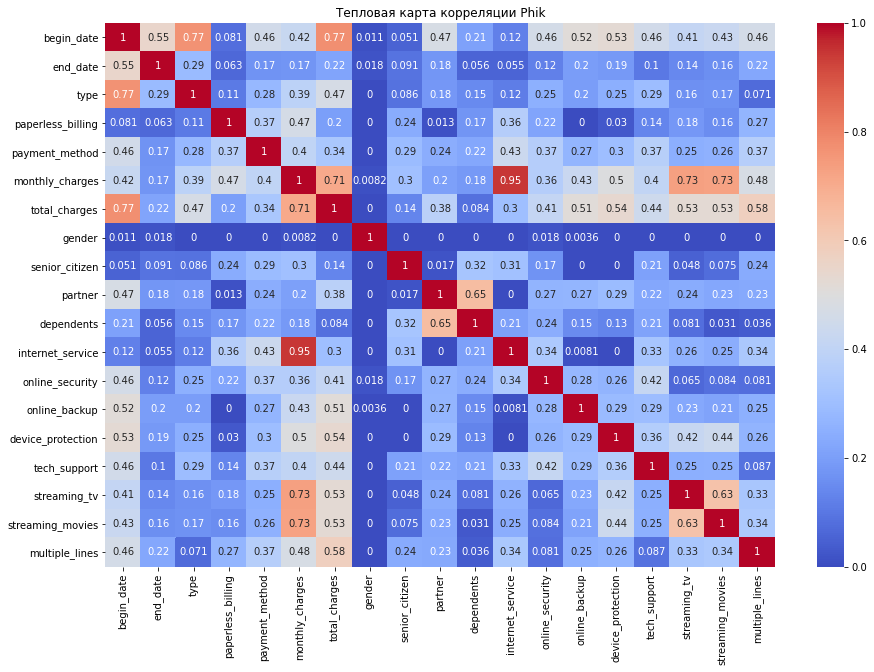

In [21]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_report, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Phik')
plt.show()

In [22]:
df = df.fillna('No')

In [23]:
df.duplicated().sum()

0

## Промежуточные выводы

В первичном осмотре 4 исходные таблицы объединили в одну по полю userID, таким образом получив 20 переменных в одной таблице.
отмечены следующие моменты: 
+ в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` 21.7% пропусков, в `multiple_lines` 9.7%.
+ нет явных дубликатов
+ нет целевой переменной
+ мультиколлинеарность различной степени между `monthly_charges` и `internet_service`/ `streaming_tv`/ `streaming_movies	`
+ 84.4% клиентов предпочитают не разрывать контракт  
+ половина клиентов предпочитает платить ежемесячно
+ две трети клиентов получают счет по электронной почте
+ 4 способа оплаты разделены между собой на равные доли, с преобладанием электронного чека (суммарно электронные способы преобладают над аналоговыми в соотношении 70/30)
+ средний ежемесячный чек составляет 65, на гистограмме выделяется отдельная группа с суммами 18.25-30 с подохрительным пиком на 18.25.
+ примерно равное распрделение по половому признаку
+ общие затраты денег на услуги выглядят нормально
+ 16% пенсионеры
+ примерно равное между женатыми/замужними и не
+ у 30% есть иждевенцы
+ 21.7% нет интернета и как следствие нет сопряженных с ним услуг.
+ у 51.87 нет возможности подключить телефонный аппарат к нескольким линиям одновременно

что сразу сделали на данном этапе:
+ устранили пропуски 
+ превели названия столбцов к змеиному виду

что сделаем на следующих этапах
+ проведем более тщательный корреляционный анализ (с помощью библиотеки phik)
+ создадим целевую по полю end_date (ушли - 1, не ушли - 0)
+ вероятно, исправим дисбаланс классов будущего таргета

# План работы

1. Загрузка и ознакомление с данными
3. Первичный анализ данных
4. Предварительные выводы
5. Этапы обучения и контроль качества моделей
    + Подготовка выборки для обучения: например, удаление столбцов после проверки Feature Importance
    + Обучение моделей: вероятнее всего LogisticRegression, RandomForestClassifier, CatBoostClassifier
    + Тест лучшей модели, проверка на адекватность
6. Финальные выводы

В ходе работы могут появляться дополнитльные подпункты, но в целом структура будет такой. Дополнительных вопросов на данном этапе нет, но как и подпункты они могут возникнуть в ходе работы.

## Подготовка признаков

In [24]:
# создадим целевой признак, где 1 - клиент ушел, 0 - клиент не ушел
df['exited'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

Заменим No на последнюю актуальную дату и добавим колонку tenure, в которой отразим сколько дней человек является клиентом.

In [25]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

In [26]:
df['tenure'] = (pd.to_datetime(df['end_date']) - pd.to_datetime(df['begin_date'])).dt.days

In [27]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,tenure
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [28]:
# проведем повтороный корреляционный анализ после преобразований
corr_df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
interval_cols = ['monthly_charges', 'total_charges']
corr_report = corr_df.phik_matrix(interval_cols=interval_cols)

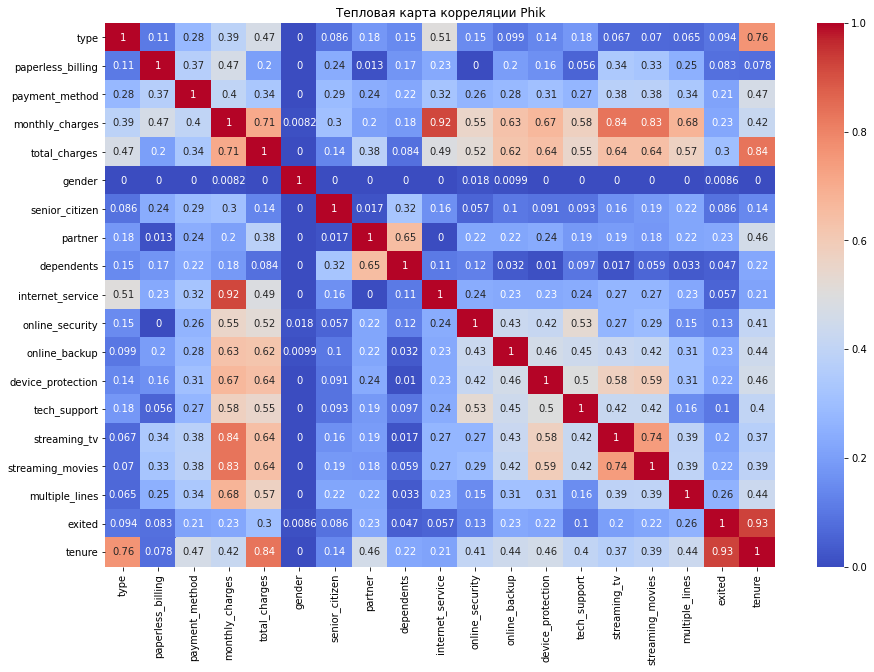

In [29]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_report, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Phik')
plt.show()

Отмечаем сильную, выше 0.8, мультиколлинеарность между `monthly_charges` и `internet_service`/ `streaming_tv`/ `streaming_movies.` Среднюю 0.5-0.7 между `monthly_charges`, `total_charges` и `online_security`, `online_backup`, `device_protection`, `tech_support`, `multiple_lines`.

Т.к. мультиколлинеарность может сделать нашу будущую модель чувствительной к малейшим изменениям в данных, поэтому столбцы с высоким показателем удалим.

Также отмечаем, что между `tenure` `type` и `total_charges` и `exited` есть зависимость. 

In [30]:
df_dropped = df.drop(['customer_id', 'begin_date', 'end_date', 
                     'internet_service', 'streaming_tv', 'streaming_movies'], axis=1)

In [31]:
# объявление переменных: с признаками и целевым признаком
features = df_dropped.drop(['exited'], axis=1)
target = df_dropped['exited']

In [32]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=random_state, stratify=target
)

In [33]:
# соотношение выборок по объему
print(f"train = {100*len(features_train)/len(df_dropped):.2f}%")
print(f"test = {100*len(features_test)/len(df_dropped):.2f}%")

train = 75.00%
test = 25.00%


In [34]:
# создадим список категориальных признаков, которые необходимо прокодировать
cat_features_OE = df_dropped.select_dtypes(include='object').columns.to_list()
cat_features_OE

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines']

In [35]:
encoder = OrdinalEncoder()

# Обучение кодировщика на обучающей выборке
encoder.fit(features_train[cat_features_OE])

# Применение кодировщика к обучающей и тестовой выборкам
features_train_temp = pd.DataFrame(encoder.transform(features_train[cat_features_OE]),
                                      columns=df_dropped[cat_features_OE].columns)
features_test_temp = pd.DataFrame(encoder.transform(features_test[cat_features_OE]),
                                     columns=df_dropped[cat_features_OE].columns)

In [38]:
# вернем закодированные признаки обратно в базу
features_train = features_train.reset_index(drop=True)
features_train[cat_features_OE] = features_train_temp[cat_features_OE]
features_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,multiple_lines,tenure
0,2.0,0.0,0.0,25.55,1886.61,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2163
1,1.0,1.0,0.0,70.45,1972.60,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,852
2,0.0,1.0,2.0,35.90,1005.20,0.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,853
3,1.0,0.0,2.0,110.35,3728.73,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,945
4,0.0,1.0,2.0,105.50,2637.50,1.0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,761


In [39]:
features_test = features_test.reset_index(drop=True)
features_test[cat_features_OE] = features_test_temp[cat_features_OE]
features_test.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,multiple_lines,tenure
0,0.0,1.0,2.0,83.60,501.60,0.0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,184
1,2.0,0.0,1.0,25.45,293.95,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,334
2,1.0,0.0,3.0,54.45,1999.40,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1095
3,2.0,1.0,0.0,59.75,4328.89,1.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2102
4,1.0,0.0,1.0,20.05,590.07,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,822


In [40]:
# разбиваем на фолды с сохранением баланса классов и перемешиваем данные
splits = StratifiedKFold(n_splits=9, shuffle=True, random_state=random_state)

## Обучение моделей

### DecisionTreeClassifier

In [41]:
%%time

model_DTC = DecisionTreeClassifier(random_state=random_state, class_weight='balanced')
parametrs_DTC = {'max_depth': [1,10]}


DTC_grid = GridSearchCV(model_DTC, parametrs_DTC, n_jobs=-1, cv=splits, scoring='roc_auc')
DTC_grid.fit(features_train, target_train)

CPU times: user 296 ms, sys: 112 µs, total: 297 ms
Wall time: 295 ms


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=150523, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=150523),
             n_jobs=-1, param_grid={'max_depth': [1, 10]}, scoring='roc_auc')

In [42]:
result_DTC = DTC_grid.best_score_
print(f"DecisionTreeClassifier: {result_DTC:.3f}")
print("Best Parameters:", DTC_grid.best_params_)

DecisionTreeClassifier: 0.721
Best Parameters: {'max_depth': 10}


### RandomForestClassifier

In [43]:
%%time

RFC = RandomForestClassifier(random_state=random_state, class_weight='balanced')
parametrs_RFC = {'max_depth': [1,10],'n_estimators': [100,300,10]}


RFC_grid = GridSearchCV(RFC, parametrs_RFC, n_jobs=-1, cv=splits, scoring='roc_auc')
RFC_grid.fit(features_train, target_train)

CPU times: user 21.8 s, sys: 160 ms, total: 21.9 s
Wall time: 22 s


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=150523, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=150523),
             n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 300, 10]},
             scoring='roc_auc')

In [44]:
result_RFC = RFC_grid.best_score_
print(f"RandomForestRegressor: {result_RFC:.3f}")
print("Best Parameters:", RFC_grid.best_params_)

RandomForestRegressor: 0.823
Best Parameters: {'max_depth': 10, 'n_estimators': 300}


### CatBoostClassifier

In [45]:
CBC = CatBoostClassifier(eval_metric = 'AUC', 
                         random_state=random_state,
                         verbose=1000,
                         iterations = 200,
                         auto_class_weights='Balanced',
                         learning_rate = 0.5)
parameters_CBC = {'depth':[5,10]}


grid_search_CBC = GridSearchCV(estimator=CBC, param_grid=parameters_CBC, scoring='roc_auc', cv=splits)
grid_search_CBC.fit(features_train, target_train)


0:	total: 48ms	remaining: 9.55s
199:	total: 392ms	remaining: 0us
0:	total: 1.84ms	remaining: 367ms
199:	total: 340ms	remaining: 0us
0:	total: 2.62ms	remaining: 520ms
199:	total: 348ms	remaining: 0us
0:	total: 1.8ms	remaining: 358ms
199:	total: 401ms	remaining: 0us
0:	total: 1.96ms	remaining: 390ms
199:	total: 411ms	remaining: 0us
0:	total: 1.96ms	remaining: 389ms
199:	total: 370ms	remaining: 0us
0:	total: 2.05ms	remaining: 408ms
199:	total: 372ms	remaining: 0us
0:	total: 2.2ms	remaining: 437ms
199:	total: 398ms	remaining: 0us
0:	total: 2.05ms	remaining: 408ms
199:	total: 397ms	remaining: 0us
0:	total: 18.9ms	remaining: 3.76s
199:	total: 3.43s	remaining: 0us
0:	total: 16.5ms	remaining: 3.28s
199:	total: 3.28s	remaining: 0us
0:	total: 15.7ms	remaining: 3.12s
199:	total: 3.29s	remaining: 0us
0:	total: 19.1ms	remaining: 3.81s
199:	total: 3.42s	remaining: 0us
0:	total: 25.5ms	remaining: 5.07s
199:	total: 3.04s	remaining: 0us
0:	total: 18.3ms	remaining: 3.64s
199:	total: 3.08s	remaining: 0us

GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=150523, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3667b6a970>,
             param_grid={'depth': [5, 10]}, scoring='roc_auc')

In [46]:
best_params = grid_search_CBC.best_params_
best_model_CBC = grid_search_CBC.best_estimator_
score = grid_search_CBC.best_score_


print("Best Parameters:", best_params)
print(f"ROC AUC Score: {score:.3f}")

Best Parameters: {'depth': 5}
ROC AUC Score: 0.896


In [47]:
# поместим полученный результаты в таблицу
compare = {
    'model':['DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
    'ROC-AUC':[0.721, 0.823, 0.896]}
pd.DataFrame(compare)

,model,ROC-AUC
0,DecisionTreeClassifier,0.721
1,RandomForestClassifier,0.823
2,CatBoostClassifier,0.896


Наилучший результат показала модель `CatBoostClassifier`.

## Тестирование

In [48]:
# ROC-AUC
CBC = CatBoostClassifier(eval_metric = 'AUC', 
                         random_state=random_state,
                         verbose=1000,
                         iterations = 200,
                         depth = 5,
                         auto_class_weights='Balanced',
                         learning_rate = 0.5)

CBC.fit(features_train, target_train)

probabilities_test = CBC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


print(f'ROC AUC Score: {roc_auc_score(target_test, probabilities_one_test):.3f}')

0:	total: 2.44ms	remaining: 487ms
199:	total: 424ms	remaining: 0us
ROC AUC Score: 0.906


In [49]:
# accuracy_score

predictions = CBC.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

print(f'Accuracy Score: {accuracy:.3f}')

Accuracy Score: 0.879


In [50]:
# проверка на адекватность
dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)


dummy_accuracy = accuracy_score(target_test, dummy_pred)
print(f"DummyClassifier accuracy: {dummy_accuracy:.3f}")

DummyClassifier accuracy: 0.844


In [51]:
# матрица ошибок на тестовой выборке
conf_matrix = confusion_matrix(target_test, predictions)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1353  133]
 [  80  195]]


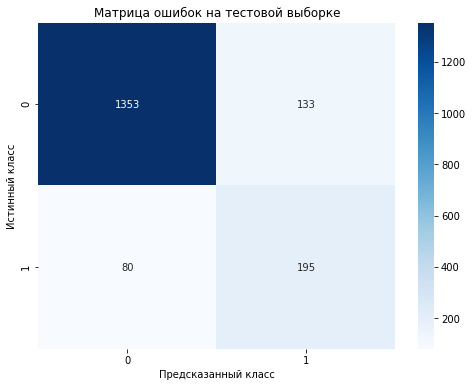

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()


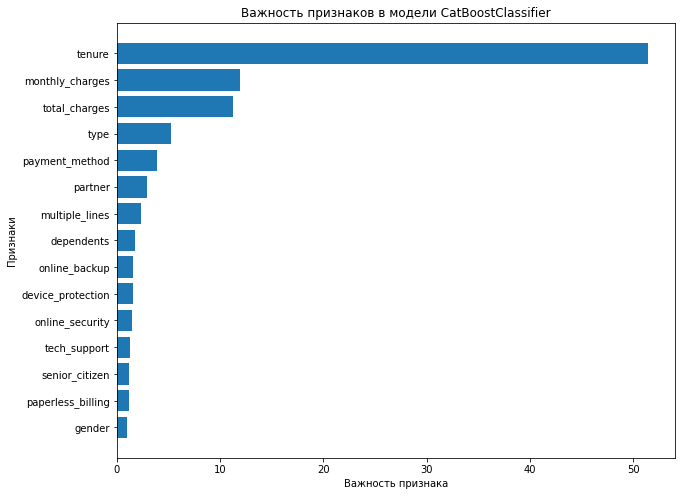

In [53]:
# смотрим на важность признаков
feature_importance = CBC.feature_importances_

feature_names = features_train.columns

sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 8))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели CatBoostClassifier')
plt.show()

**Промежуточный вывод:**
+ лучший результат среди трех моделей показала CatBoostClassifier с гиперпараметрами: depth=5, learning_rate=0.5, iterations=200
+ выбранная модель прошла тест с ROC-AUC **0.906** и Accuracy **0.879**, также прошла тест на адекватность
+ матрица ошибок показала, что модель великоепно справляется с предсказанием Negative значений, а также предсказала 3/4 Positive значений
+ наибольшее влияние на модель оказывает признак `tenure` - длительность обслуживания клиента, а так же сумма: `total_charges`,`monthly_charges`, `type`, `payment_method`. Об остальных признаках можно сказать, что они менее существенны для моделирования.

## Финальные выводы

**Краткое содержание:**

В ходе проекта мы объединили данные и провели анализ, выявив зависимости и дисбаланс классов. Обработали пропущенные значения и исключили линейно зависимые признаки. Обучили несколько моделей и выбрали лучшую - CatBoostClassifier, с которой достигли ROC-AUC 0.909 и accuracy **0.894** на тестовых данных. Основные влияющие признаки оказались *длительность обслуживания, общая и ежемесячная плата, тип и метод оплаты*. Ниже можно узнать подробнее о каждом из этапов.

1. **Ключевые шаги**
   - Загрузка и ознакомление с данными: объединение данных из разных источников в одну таблицу для удобства анализа.
   - Первичный анализ данных: визуализация и статистический анализ данных помогли выявить дисбаланс классов(см.ниже), пропущенные значения и зависимости между переменными.
   - Сделали промежуточные выводы на основе результатов первичного анализа данных и определили дальнейшие шаги работы.
   - Этапы обучения и контроль качества моделей:
     - Подготовка признаков: удаление наименее информативных признаков и добавиление недостающих.
     - Обучение и сравнение моделей: DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier. Для подбора гиперпараметров использовали метод GridSearchCV.
     - Тестирование: Проверили качество моделей на тестовых данных метриками ROC-AUC и accuracy.
   - Финальные выводы: ===вы находитесь здесь===

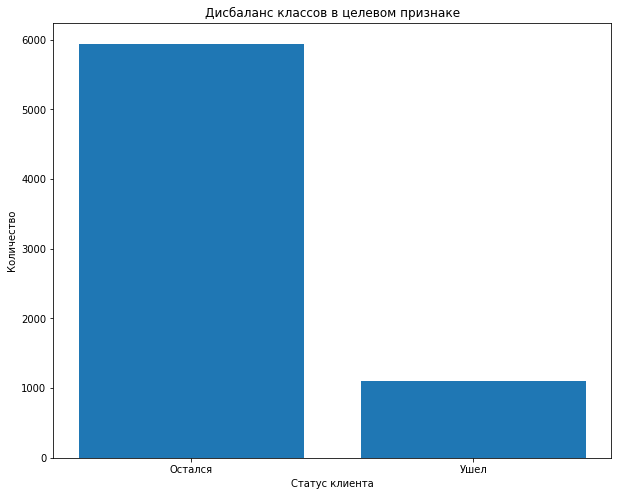

2. **Подробнее о features**
   - Обнаружили, что признаки `monthly_charges`, `internet_service`, `streaming_tv` и `streaming_movies` имеют сильную линейную зависимость друг от друга. Это может вызвать проблемы при обучении модели и интерпретации результатов, поэтому исключили эти признаки из рассмотрения, оставив только monthly_charges (подробнее о зависимости см. рис. ниже).

   - Создали целевой признак на основе информации о дате окончания контракта. Если данные об уходе клиента отсутствуют, считаем его действующим клиентом и присваиваем значение 0, в противном случае - 1.
   - Добавили признак `tenure`, который отражает количество дней, проведенных клиентом в компании. Признак рассчитан как разница между датами окончания и начала контракта, учитывая актуальную дату (2020-02-01) в случае отсутствия данных об окончании.
   - Сохранили дисбаланс классов при разбиении выборки на части методом стратификации.

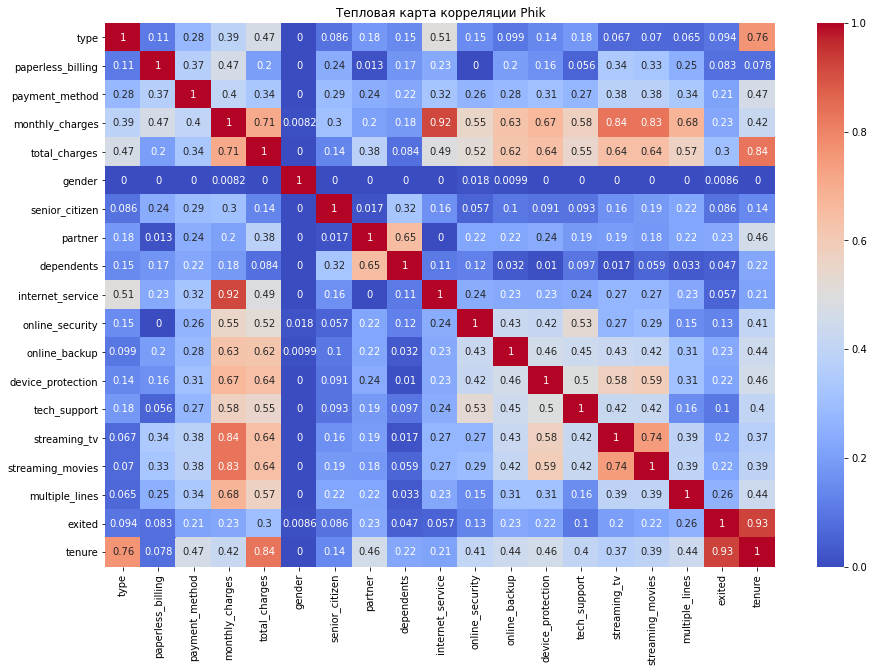

3. **Обработка данных**
   - Пропущенные значения в признаке `total_charges`, которые, скорее всего, вызваны тем, что новые клиенты еще не оплатили свои счета, заполнили значением 0.
   - После объединения данных в одну таблицу были обнаружены пропуски в связанных с интернет-услугами колонках, таких как `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, и в признаке `multiple_lines`. Вероятно, это связано с тем, что некоторые клиенты не пользуются этими услугами, поэтому данных о них отсутствуют. Пропуски были заполнены соответствующими значениями.


4. **Лучшая модель и ее результаты**
   - Для DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier подобрали наилучшие гиперпараметры методом GridSearchCV. Для сравнения использовали метрику ROC-AUC. Ниже таблица результатов сравнения.
   - Лучшая модель по результатам - **CatBoostClassifier** с AUC-ROC = 0.896 и с гиперпараметрами `depth=5`, `learning_rate=0.5`, `iterations=200`.
   - На тестовых данных модель показала ROC-AUC 0.906 при необходимом ROC-AUC >= 0.85 и accuracy **0.879**, который более чувствительный к дисбалансу классов чем ROC-AUC. Модель также успешно прошла проверку на адекватность (см.матрицу ошибок финальной модели ниже).
   - Проверка модели на адекватность.

*Таблица сравнения результатов моделей:*

In [54]:
compare = {
    'model':['DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
    'ROC-AUC':[0.721, 0.823, 0.896]}
pd.DataFrame(compare)

,model,ROC-AUC
0,DecisionTreeClassifier,0.721
1,RandomForestClassifier,0.823
2,CatBoostClassifier,0.896


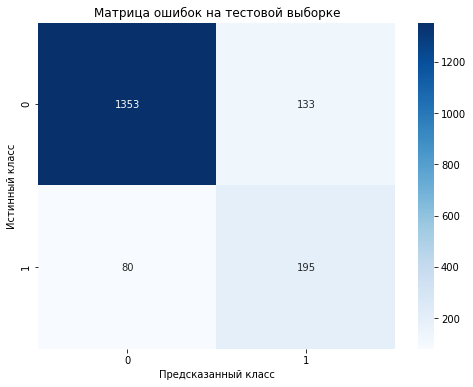


6. **Выводы по анализу важности признаков**
   - Наибольшее влияние на модель оказывают признаки `tenure` (длительность обслуживания клиента), а также суммарные признаки: `total_charges`, `monthly_charges`, `type`, `payment_method`. Остальные признаки имеют меньшую значимость для моделирования (подробнее см. рис. ниже).

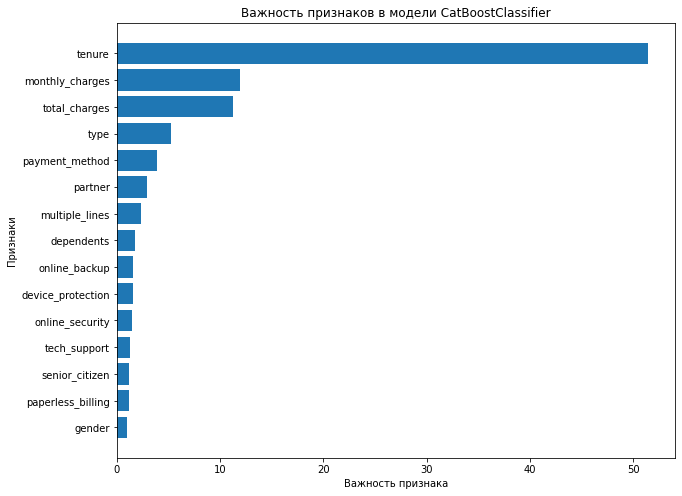

Резюмируя, на основе проведенного анализа и обучения моделей, можно рекомендовать использовать модель CatBoostClassifier для решения задачи удержания клиентов. Модель показала лучшие результаты по ключевым метрикам, что доказывает её способность предсказывать, останется ли клиент или уйдет, основываясь на имеющихся данных.

Однако перед внедрением модели в работу, рекомендуется провести анализ прогнозных значений и дополнительное тестирование на независимых данных, чтобы убедиться в ее надежности и стабильности. По результатам которого, можно провести дополнительную оптимизацию модели, настроив ее гиперпараметры. В ходе внедрения в работу, рекомендуется мониторинг модели и обновление данных.